# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2018 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original Denoising AutoEncoder example from:

Links:
    [Keras Denoising AutoEncoder] https://blog.keras.io/building-autoencoders-in-keras.html
</pre>

In [0]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [0]:
# Különbségek az MNIST-es példához képest
# - MNIST helyett CIFAR-10
#    (keras.datasets.cifar10)
# - képek mérete a CIFFAR-10-hez illeszkedve
#    (32x32x3)
# - háló RGB csatornás képet tudjon kezelni
#    (az MNIST-ben szürkeárnyalatos képek vannak, a CIFAR-10-ben színesek)
# - háló módosítása, hogy jobb legyen a zajszűrés
#    (mnist-hez képest kevesebb réteg segít)


input_img = Input(shape=(32,32,3))

In [0]:
# enkóder
x = Convolution2D(32, (3,3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2,2), padding='same')(x)


In [0]:
# dekóder
x = Convolution2D(32, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
decoded = Convolution2D(3, (3,3), activation='sigmoid', padding='same')(x)

In [0]:
# teljes AE háló
autoencoder = Model(inputs = input_img, outputs = decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adadelta', loss = 'binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 3)         867       
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [0]:
# tanítóadatok
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

(x_train, _) ,(x_test, _) = cifar10.load_data()

print(x_train.shape, x_test.shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# itt már nem kell 4D-re alakítani
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [0]:
# fehérzaj hozzákeverése a tanítóadatokhoz
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

In [0]:
# 0-1 közé
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

print(x_test_noisy[0].shape)

(32, 32, 3)


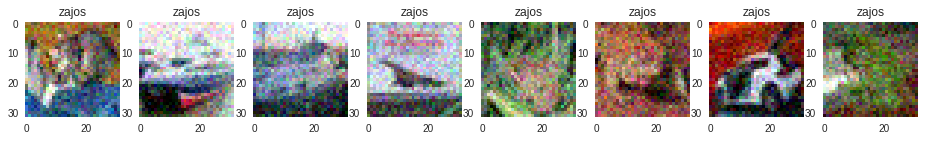

In [0]:
# zajos képek
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(1, n, i + 1)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(32,32,3))
  plt.gray()
  ax.grid('False')

In [0]:
# tanítás
# bemenet: zajos képek
# kimenet: eredeti (zajmentes) képek
autoencoder.fit(x_train_noisy, x_train,
               epochs = 5,
               batch_size = 128,
               shuffle = True,
               validation_data = (x_test_noisy, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 9s 176us/step - loss: 0.5903 - val_loss: 0.5732
Epoch 2/5
50000/50000 [==============================] - 8s 166us/step - loss: 0.5691 - val_loss: 0.5654
Epoch 3/5
50000/50000 [==============================] - 8s 163us/step - loss: 0.5643 - val_loss: 0.5638
Epoch 4/5
50000/50000 [==============================] - 8s 165us/step - loss: 0.5615 - val_loss: 0.5618
Epoch 5/5
50000/50000 [==============================] - 8s 163us/step - loss: 0.5599 - val_loss: 0.5608


In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

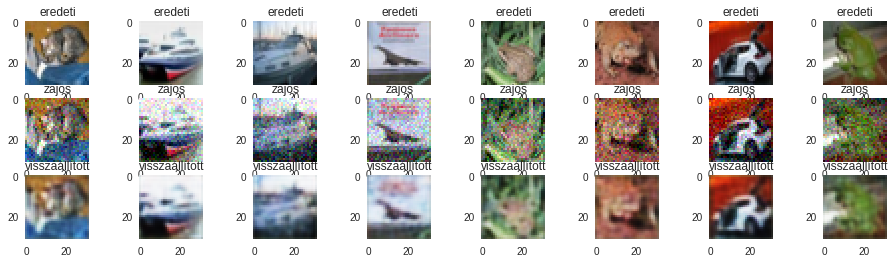

In [30]:
# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.gray()
  ax.grid('False')
  
  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(32,32,3))
  plt.gray()
  ax.grid('False')
  
  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(32,32,3))
  plt.gray()  
  ax.grid('False')
plt.show()